In [ ]:
import torch
import numpy

#### What exactly an LSTM returns and shapes the data

In [ ]:
input_tensor = torch.tensor([[[1., 1., 1.],
                              [2., 2., 2.],
                              [3., 3., 3.]]])
input_size = input_tensor.size(-1)
hidden_size = 3
lstm = torch.nn.LSTM(input_size=input_size,
                     hidden_size=hidden_size,
                     num_layers=1,
                     batch_first=True)
output, (h_n, c_n) = lstm(input_tensor)
output, (h_n, c_n)

In [ ]:
print(f"output size: {output.size()}, (batch_size, seq_len, H_out)")
print(f"h_n size:    {h_n.size()}, (batch_size, num_layers, H_out)")
print(f"c_n size:    {c_n.size()}, (num_layers, batch_size, H_cell)")

In [ ]:
input_tensor = torch.tensor([[[1., 1., 1.],
                              [2., 2., 2.],
                              [3., 3., 3.],
                              [4., 4., 4.]]])

In [ ]:
x = input_tensor
x = x.permute(0, 2, 1)
x

## Setting generator seeds

In [23]:
%load_ext autoreload
%autoreload

from architectures import COTGAN
from utils import DatasetSinus, log_visualizations
from trainer import cotgan_trainer, cotgan_generator
from metrics import *
import numpy as np
import torch
import matplotlib.pyplot as plt

seed = 42
alpha = 0.7
noise = 0
np.random.seed(seed)
torch.manual_seed(seed)

device = "cpu"
trainset = DatasetSinus(num=6*12, seq_len=25, alpha=alpha, noise=noise, device=device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
sin1 freq:[1, 3], phase:[-1.5707963267948966, 0]
sin2 freq:[4, 6], phase:[0, 1.5707963267948966]


In [24]:
trainset[:6][0].shape

torch.Size([6, 25, 3])

In [25]:
params = {
    "model_name": "model_cotgan.pt",
    "n_epochs": 1,
    "l_rate": 0.001, # for both D and G
    "batch_size": 32,
    "dis_rnn_num_layers": 1,
    #"dis_rnn_hidden_dim": 20,
    "gen_rnn_num_layers": 2,
    "gen_rnn_hidden_dim": 5,
    "hidden_dim": 10, # generator: hidden dim in FC, discriminator: filters in Convolution
    "num_hidden_layers": 2, # generator fully-connected layers

    "scaling_coef": 1.0, # distance scaling (TODO(Not implemented))
    "sinkhorn_eps": 0.8, # epsilon regularizer
    "sinkhorn_l":   100, # sinkhorn calculation iterations
    "reg_lam":      10.0, # martingale penalty coefficient

    "Z_dim": 20,
    "optimizer": "Adam", # RMSprop, Adam
    "beta1": 0.5,
    "beta2": 0.9,
    "dataset": "sines",
    "feature_dim": trainset[0][0].size(1),
    "max_seq_len": trainset[0][0].size(0),
    "trainset_size": len(trainset),
    "device": device,
}

model = COTGAN(params)

In [26]:
z1 = torch.randn(6,params["max_seq_len"], params["Z_dim"])
z2 = torch.randn(6,params["max_seq_len"], params["Z_dim"])

x1 = trainset[:6][0]
x2 = trainset[6:12][0]

In [33]:
model(z1,z2,x1,x2, obj="discriminator")

tensor(3.3174, grad_fn=<AddBackward0>)

In [32]:
x1.size()

torch.Size([6, 25, 3])

In [1]:
import torch
batch_size = 6
seq_len = 25
dim_size = 3
x = torch.randn(batch_size, seq_len, dim_size)

In [87]:
import numpy as np
import matplotlib.pyplot as plt

In [153]:
# def create_sin_wave but writte with torch
def create_sin_wave(spatial_len=25, seq_len=10):
    e = torch.rand(1) * 0.6
    x = torch.linspace(0, 1, spatial_len) + e
    time = torch.linspace(0, 0.3, seq_len)
    amplitude = 0.5
    freq = 1.5
    y = amplitude * torch.sin( 2 * np.pi * freq * (x + time[:, None])) + 0.5
    #plt.plot(y.T[:,:]);
    return y
create_sin_wave(spatial_len=50, seq_len=25);

In [424]:
batch_size = 32
hidden_dim = 10
rnn_hidden_dim = 15
max_seq_len = 25
spatial_len = 50
data = torch.stack([create_sin_wave(spatial_len=spatial_len, seq_len=max_seq_len) for _ in range(batch_size)])
data.size()

torch.Size([100, 25, 50])

In [437]:
# DISCRIMINATOR
disc = torch.nn.Sequential(torch.nn.Conv1d(in_channels=1, out_channels=hidden_dim, kernel_size=5, stride=1, padding=2),
                           torch.nn.BatchNorm1d(hidden_dim),
                           torch.nn.ReLU(),
                           torch.nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim*2, kernel_size=5, stride=1, padding=2),
                           torch.nn.BatchNorm1d(hidden_dim*2),
                           torch.nn.ReLU(),
                           )

rnn = torch.nn.GRU(input_size=hidden_dim * 2 * spatial_len, hidden_size=rnn_hidden_dim, num_layers=1, batch_first=True)

In [789]:
# forward pass
batch_size = 32
max_seq_len = 25
spatial_len = 50
data = torch.rand(batch_size, max_seq_len, spatial_len)
print(f"input size: \t\t{data.size()}")
x = data.view(batch_size*max_seq_len, 1, -1)
print(f"input size: \t\t{x.size()}")
x = disc(x)
print(f"disc output size:   {x.size()}")
x = x.view(batch_size, max_seq_len, -1)
print(f"rnn input size: \t{x.size()}")
x, _ = rnn(x)
print(f"rnn output size: \t{x.size()}")



input size: 		torch.Size([32, 25, 50])
input size: 		torch.Size([800, 1, 50])
disc output size:   torch.Size([800, 20, 50])
rnn input size: 	torch.Size([32, 25, 1000])
rnn output size: 	torch.Size([32, 25, 15])


In [808]:
max_seq_len = 25
x = torch.randn(batch_size, max_seq_len , spatial_len)
hidden_dim = 20
m1 = torch.nn.Conv1d(in_channels=1, out_channels=hidden_dim, kernel_size=5, stride=1, padding=2)
m2 = torch.nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim*2, kernel_size=5, stride=1, padding=2)
x = x.view(batch_size*max_seq_len, 1, -1)
x = m1(x)
x = m2(x)
#x.size()
print(x.size())
x = x.view(batch_size, max_seq_len, -1)
print(x.size())
2000 == 20 * 50 * 2

torch.Size([800, 40, 50])
torch.Size([32, 25, 2000])


True

In [444]:
# GENEARATOR
batch_size = 16
Z_dim = 10
gen_rnn_hidden_dim = 25
gen_rnn = torch.nn.GRU(input_size=Z_dim,
                        hidden_size=gen_rnn_hidden_dim,
                        num_layers=1,
                        batch_first=True)
gen_rnn2 = torch.nn.GRU(input_size=gen_rnn_hidden_dim,
                        hidden_size=gen_rnn_hidden_dim * 2,
                        num_layers=1,
                        batch_first=True)
linear = torch.nn.Linear(in_features=gen_rnn_hidden_dim * 2, out_features=1)

In [446]:
x = torch.randn(batch_size, max_seq_len, Z_dim)
print(f"input size: \t\t\t{x.size()}")
x, _ = gen_rnn(x)
print(f"gen_rnn output size: \t{x.size()}")
x, _ = gen_rnn2(x)
print(f"gen_rnn2 output size: \t{x.size()}")
x = linear(x)
print(f"linear output size: \t{x.size()}")


input size: 			torch.Size([16, 25, 10])
gen_rnn output size: 	torch.Size([16, 25, 25])
gen_rnn2 output size: 	torch.Size([16, 25, 50])
linear output size: 	torch.Size([16, 25, 1])


In [447]:
def grid(P=20, M=100):
    dx = P/M
    x = np.linspace(0, P-dx, M)
    return x, dx

In [652]:
c = 2 # the speed, and two times the height of the wave
P = 20 # period
M = 50 # number of spatial points
x, dx = grid(P, M)
x += P/4 # start the wave at x=5
sech = lambda a: 1/np.cosh(a) # sech isn't defined in NumPy
u_soliton = lambda x, t: 1/2*c*sech(np.abs((x-c*t) % P - P/2))**2

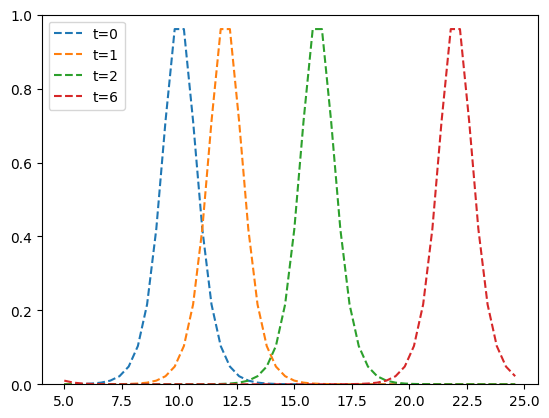

In [653]:
plt.plot(x, u_soliton(x, 0), '--', label="t=0")
plt.plot(x, u_soliton(x, 1), '--', label="t=1")
plt.plot(x, u_soliton(x, 3), '--', label="t=2")
plt.plot(x, u_soliton(x, 6), '--', label="t=6")
plt.ylim(0, 1)
plt.legend()

In [743]:
# create a dataset of soliton waves

class SolitonDataset(torch.utils.data.Dataset):
    def __init__(self, n_samples, P, t_range, c_range, spatial_len=50, t_steps=25):
        self.t_range = t_range # [0, 6]
        self.c_range = c_range #[0.5, 2]
        self.P = P # period
        self.n_samples = n_samples
        self.t_steps = t_steps
        self.spatial_len = spatial_len # M
        self.data = self.create_soliton_dataset_torch()

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.data[idx]

    def create_soliton_dataset_torch(self):
        sech = lambda a: 1/torch.cosh(a) # sech isn't defined in NumPy
        u_soliton_t = lambda x, t, c, P: 1/2*c*sech(torch.abs((x-c*t) % P - P/2))**2

        def grid(P, M):
            dx = P/M
            x = torch.linspace(0, P-dx, M)
            return x, dx

        data = torch.zeros((self.n_samples, self.t_steps, self.spatial_len))
        # random speed =c
        c_arr = torch.FloatTensor(self.n_samples).uniform_(self.c_range[0], self.c_range[1])
        t = torch.linspace(t_range[0], t_range[1], self.t_steps)
        x, dx = grid(self.P, self.spatial_len)
        x += P/4 # start the wave at x=5
        for i in range(self.n_samples):
            c = c_arr[i]
            u = u_soliton_t(x, t[:, None], c, self.P)
            data[i] = u
        return data


In [744]:
# Global parameters [min, max]
c_range = [0.5, 2] # torch.uniform(0.5, 2)
t_range = [0, 6] # torch.linspace(0, 3, t_steps)
t_steps = 25
dataset = SolitonDataset(n_samples=100, P=20, t_range=t_range, c_range=c_range, spatial_len=M, t_steps=t_steps)

In [745]:
dataloader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=16,
        shuffle=True
    )

torch.Size([16, 25, 50])


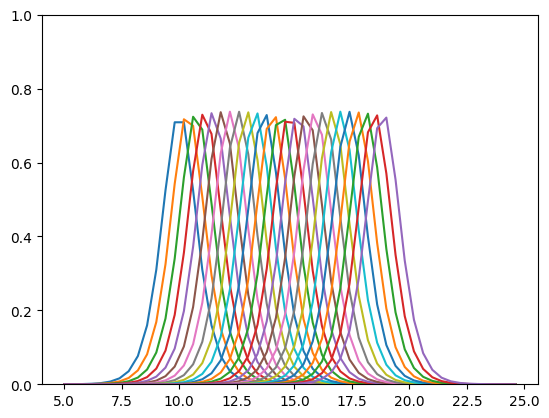

In [785]:
for X_mb in dataloader:
    print(X_mb.size())
    plt.plot(x, X_mb[0].T)
    plt.ylim(0, 1)
    break